# Benchmark Chips

## Benchmark chips using mirror circuit

In [7]:
import networkx as nx
from tensorcircuit.results import qem
from tensorcircuit.results.qem import benchmark_circuits
import random
import numpy as np

from tensorcircuit.cloud import apis
from tensorcircuit.results import counts
from tensorcircuit.compiler.qiskit_compiler import qiskit_compile
from matplotlib import cm

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
d = apis.get_device("tianxuan_s1")
couple_list = d.topology()
print(couple_list)

[[0, 1], [6, 2], [4, 0], [0, 4], [8, 4], [1, 5], [3, 7], [0, 3], [2, 0], [5, 1], [3, 0], [7, 3], [0, 2], [2, 6], [4, 8], [1, 0]]


nq: [0, 1] depth: 1 success 4.1484000000000005
nq: [0, 1] depth: 2 success 3.7722999999999995
nq: [0, 1, 2] depth: 1 success 3.2711
nq: [0, 1, 2] depth: 2 success 3.2814
nq: [0, 1, 2, 3] depth: 1 success 3.1682000000000006
nq: [0, 1, 2, 3] depth: 2 success 2.5158
nq: [0, 1, 2, 3, 4] depth: 1 success 2.1039999999999996
nq: [0, 1, 2, 3, 4] depth: 2 success 1.4552999999999998


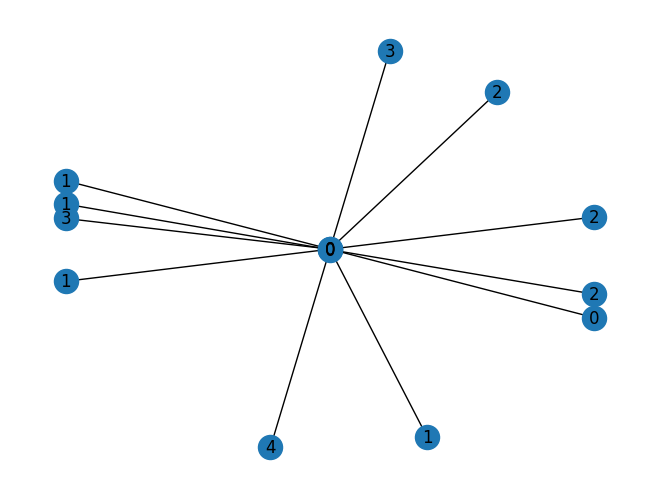

In [15]:
result_list = []


for nq in range(2, 6):
    qlis = list(range(nq))
    graph = []
    for i in range(len(couple_list)):
        if couple_list[i][0] in qlis and couple_list[i][1] in qlis:
            graph.append(couple_list[i])

    G = nx.Graph()
    G.add_edges_from(graph)
    nx.draw(G, with_labels=True)

    for depth in range(1, 3):
        A = 0
        for numc in range(5):
            c, ideal = benchmark_circuits.mirror_circuit(
                depth=depth,
                two_qubit_gate_prob=1,
                connectivity_graph=G,
                seed=random.randint(0, 100),
            )  # includes np.sqrt(X)^{\dagger} gate,identity gate

            c1, info = qiskit_compile(
                c,
                compiled_options={
                    "basis_gates": ["h", "rz", "x", "y", "z", "cz"],
                    "optimization_level": 2,
                    # "coupling_map": d.topology(),
                },
            )

            t = apis.submit_task(
                circuit=c1,
                shots=10000,
                device=d,
                enable_qos_qubit_mapping=False,
                enable_qos_gate_decomposition=False,
            )
            raw_count = t.results(blocked=True)  # position_counts=logical_counts
            # print("raw",raw_count[list(ideal.keys())[0]]/10000)

            A += raw_count[list(ideal.keys())[0]] / 10000
        print("nq:", qlis, "depth:", depth, "success", A)
        result_list.append(A)

In [16]:
result_list1 = [i / 5 for i in result_list]
result_list2 = np.reshape(result_list1, [4, 2])

Text(0, 0.5, 'Depth')

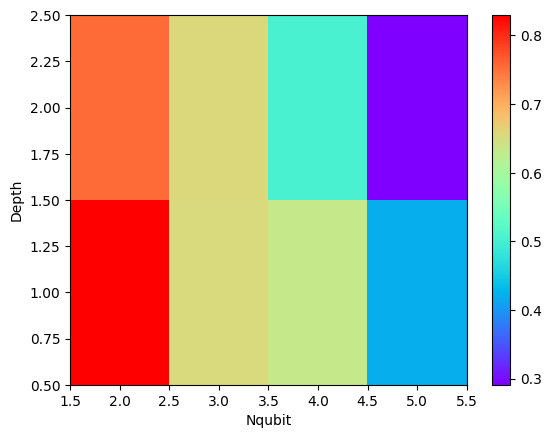

In [17]:
fig, ax = plt.subplots()
Z = np.transpose(result_list2)
X = list(range(2, 6))
Y = list(range(1, 3))
p = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), cmap="rainbow")
cb = fig.colorbar(p, ax=ax)
plt.xlabel("Nqubit")
plt.ylabel("Depth")